In [10]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision.io import read_image
import torchvision.transforms.v2 as transformsv2
import sys
torch.manual_seed(42)

sys.path.append("..")

RESNET18_HEIGHT = 224
RESNET18_WIDTH = 224

class RFW(Dataset):

    def __init__(self, img_path, attr_path, transforms, png):

        self.attr = pd.read_csv(attr_path).to_numpy()
        print(f'attr: {self.attr}')
        self.img_path = img_path
        self.transforms = transforms
        self.png = png
        
    def __len__(self):
        return len(self.attr)
    
    def __getitem__(self, idx):

        if self.png:
            img =  read_image(os.path.join(self.img_path, self.attr[idx][2], self.attr[idx][1]))
        else:
            img =  read_image(os.path.join(self.img_path, self.attr[idx][2], self.attr[idx][1].replace("png", "jpg")))
        return self.transforms(img), torch.from_numpy(self.attr[idx][3:].astype(np.float32)),\
            self.attr[idx][2].split("/")[0], f'{self.attr[idx][2]}/{self.attr[idx][1]}'



def create_dataloaders(
    img_path, 
    attr_path, 
    batch_size, 
    train_test_ratio=0.7, 
    png=True, 
    seed=42
):

    tfs = transformsv2.Compose([
        transformsv2.Resize((RESNET18_HEIGHT, RESNET18_WIDTH)),
        transformsv2.ToTensor()
    ])

    # Create Dataset
    data = RFW(img_path, attr_path, tfs, png)

    generator = torch.Generator().manual_seed(seed)

    trainset_size = int(len(data) * train_test_ratio)
    validaset_size = int((len(data) - trainset_size) * 0.5)
    testset_size = len(data) - trainset_size - validaset_size

    trainset, valset, testset = random_split(data, [trainset_size, validaset_size, testset_size], generator)

    # Create data loaders
    train_loader = DataLoader(trainset, batch_size, shuffle=True)
    val_loader = DataLoader(valset, batch_size)
    test_loader = DataLoader(testset, batch_size)

    return train_loader, val_loader, test_loader

In [11]:
RACE_LABELS = ['Indian', 'Asian', 'African', 'Caucasian']
ROOT = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64'
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels_sorted.csv"
RATIO = 0.8
BATCH_SIZE = 32
model_names = ['cheng2020-attn', 'hyperprior', 'mbt2018', 'qarv', 'qres17m']
attribites = ['']
model_name = 'cheng2020-attn'
datasets_names = ['fairface', 'celebA']
dataset_name = 'celebA'

qualities = ['q_0001', 'q_0009', 'q_1', 'q_2', 'q_3']
for quality in qualities:
    train_loader, valid_loader, test_loader = create_dataloaders(
        f'{ROOT}/{model_name}/{dataset_name}/{quality}', 
        RFW_LABELS_DIR, 
        BATCH_SIZE, 
        RATIO
    )

attr: [[0 'm.011y5k_0003.png' 'African/m.011y5k' ... 1 1 0]
 [1 'm.011y5k_0004.png' 'African/m.011y5k' ... 1 1 0]
 [2 'm.011y5k_0002.png' 'African/m.011y5k' ... 1 1 0]
 ...
 [40604 'm.0_4pw_0004.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40605 'm.0_4pw_0003.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40606 'm.0_4pw_0002.png' 'Indian/m.0_4pw' ... 1 2 0]]
attr: [[0 'm.011y5k_0003.png' 'African/m.011y5k' ... 1 1 0]
 [1 'm.011y5k_0004.png' 'African/m.011y5k' ... 1 1 0]
 [2 'm.011y5k_0002.png' 'African/m.011y5k' ... 1 1 0]
 ...
 [40604 'm.0_4pw_0004.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40605 'm.0_4pw_0003.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40606 'm.0_4pw_0002.png' 'Indian/m.0_4pw' ... 1 2 0]]
attr: [[0 'm.011y5k_0003.png' 'African/m.011y5k' ... 1 1 0]
 [1 'm.011y5k_0004.png' 'African/m.011y5k' ... 1 1 0]
 [2 'm.011y5k_0002.png' 'African/m.011y5k' ... 1 1 0]
 ...
 [40604 'm.0_4pw_0004.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40605 'm.0_4pw_0003.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40606 'm.0_4pw_0002.png' 'Indian/m.0_

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transf

In [12]:
test_file_names = []
for batch in test_loader:
    test_file_names.extend(list(batch[-1]))

In [13]:
test_file_names

['Caucasian/m.04vzp3/m.04vzp3_0005.png',
 'Asian/m.06jvdd/m.06jvdd_0002.png',
 'Caucasian/m.068p19/m.068p19_0002.png',
 'African/m.09876j/m.09876j_0003.png',
 'Caucasian/m.03f1sjy/m.03f1sjy_0002.png',
 'Asian/m.02rzm97/m.02rzm97_0002.png',
 'African/m.01mvw82/m.01mvw82_0003.png',
 'Caucasian/m.0gbx3b6/m.0gbx3b6_0004.png',
 'Indian/m.0h1sgs/m.0h1sgs_0003.png',
 'African/m.01mjyj0/m.01mjyj0_0003.png',
 'African/m.0j3vxkv/m.0j3vxkv_0002.png',
 'African/m.026_y13/m.026_y13_0004.png',
 'Caucasian/m.03plx_/m.03plx__0001.png',
 'Asian/m.06c1fd/m.06c1fd_0004.png',
 'Caucasian/m.04dyc2/m.04dyc2_0003.png',
 'Caucasian/m.026ths5/m.026ths5_0002.png',
 'Indian/m.060dvc/m.060dvc_0002.png',
 'Indian/m.02qytnc/m.02qytnc_0001.png',
 'Indian/m.025xfy6/m.025xfy6_0004.png',
 'Asian/m.07pkn7/m.07pkn7_0002.png',
 'African/m.03_w4m/m.03_w4m_0002.png',
 'Indian/m.04q699/m.04q699_0001.png',
 'African/m.04lxlw/m.04lxlw_0003.png',
 'Indian/m.0c7wt7/m.0c7wt7_0001.png',
 'Asian/m.0c6c6x/m.0c6c6x_0004.png',
 'Afric

In [14]:
from tqdm import tqdm

ATTRIBUTE_INDECIES = {
    'skin_type': 0,
    'lip_type': 1,
    'nose_type': 2,
    'eye_type': 3,
    'hair_type': 4,
    'hair_color': 5
}

def save_race_based_predictions(
        models,  
        dataloader, 
        device, 
        prediction_save_dir,
        attributes
    ):
    all_predictions = {'Indian': {attr: torch.tensor([]) for attr in attributes}, 
                       'Caucasian': {attr: torch.tensor([]) for attr in attributes}, 
                       'Asian': {attr: torch.tensor([]) for attr in attributes},  
                       'African': {attr: torch.tensor([]) for attr in attributes}}
    all_labels = {'Indian': {attr: torch.tensor([]) for attr in attributes}, 
                  'Caucasian': {attr: torch.tensor([]) for attr in attributes}, 
                  'Asian': {attr: torch.tensor([]) for attr in attributes}, 
                  'African': {attr: torch.tensor([]) for attr in attributes}}
    all_file_names = {
        'Indian': {attr: [] for attr in attributes}, 
        'Caucasian': {attr: [] for attr in attributes}, 
        'Asian': {attr: [] for attr in attributes},  
        'African': {attr: [] for attr in attributes}
    }
    print(f'prediction_save_dir: {prediction_save_dir}')
    dataloader = tqdm(dataloader, desc="Getting Predictions", unit="batch")
    with torch.no_grad():
        for j, model in enumerate(models):
            model.eval()
            for _, data in enumerate(dataloader):
                inputs, labels, race, file_names = data
                file_names = np.array(list(file_names))
                race = np.array(race)

                inputs = inputs.to(torch.float).to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                for i, (head, predictions) in enumerate(outputs.items()):
                    head_preds = predictions.argmax(dim=1).cpu()

                    for race_label in all_labels:
                        race_indices = np.array((race == race_label).nonzero()[0])
                        race_predictions = head_preds[race_indices]
                        race_file_names = file_names[race_indices]
                        race_labels = labels[:, ATTRIBUTE_INDECIES[head]][race_indices]
                    
                        all_predictions[race_label][head] = torch.cat((all_predictions[race_label][head], race_predictions.to('cpu')), dim=0)
                        all_labels[race_label][head] = torch.cat((all_labels[race_label][head], race_labels.to('cpu')), dim=0)
                        all_file_names[race_label][head].extend(list(race_file_names))
    # with open(prediction_save_dir + '/sep_predictions.pkl', 'wb+') as f:
    #     pickle.dump(all_predictions, f)
    # with open(prediction_save_dir + '/sep_labels.pkl', 'wb+') as f:
    #     pickle.dump(all_labels, f)


    return all_predictions, all_labels, all_file_names

In [16]:
import pickle
from multi_head_resnet import MultiHeadResNet
all_predictions = {}
all_labels = {}
all_file_names = {}
attributes = ['eye_type', 'hair_color', 'hair_type', 'nose_type', 'skin_type']
PRED_ROOT = '/media/global_data/fair_neural_compression_data/predictions'
for model in model_names:
    all_predictions[model_name] = {}
    all_labels[model_name] = {}
    all_file_names[model_name] = {}
    for quality in qualities:
        models = []
        for attribute in attributes:
            attribute_model_path = f'{PRED_ROOT}/{model_name}/{dataset_name}/{quality}/{attribute}_best.pth'
            models.append(torch.load(attribute_model_path))
        all_file_names[model_name][quality], \
        all_labels[model_name][quality], \
        all_predictions[model_name][quality] = \
            save_race_based_predictions(
                models,  
                test_loader, 
                'cuda:1', 
                "",
                attributes
            )
        # preds_path = f'{PRED_ROOT}/{model}/{dataset_name}/{quality}/sep_predictions.pkl'
        # labels_path = f'{PRED_ROOT}/{model}/{dataset_name}/{quality}/sep_labels.pkl'
        # with open(preds_path, 'rb') as file:
        #     all_predictions[model_name][quality] = pickle.load(file)
            
        # with open(labels_path, 'rb') as file:
        #     all_labels[model_name][quality] = pickle.load(file)
        

prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.89batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 41.62batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.82batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 41.16batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 41.16batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 41.19batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 41.68batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 41.51batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.95batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.89batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 42.24batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 43.12batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.99batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.86batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 43.02batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.96batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.96batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 43.00batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 43.04batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.91batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.57batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.91batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.51batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 42.64batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:02<00:00, 43.34batch/s]


In [27]:
temp = all_file_names 
all_file_names = all_labels
all_labels = temp

In [28]:
cheng_preds, cheng_labels = all_predictions['cheng2020-attn'], all_labels['cheng2020-attn']

In [31]:
cheng_preds, cheng_file_names = cheng_file_names, cheng_preds

In [20]:
cheng_file_names = all_file_names['cheng2020-attn']

In [32]:
wrong_preds_file_names = {}

for quality in qualities:
    wrong_preds_file_names[quality] = {}
    for race in RACE_LABELS:
        wrong_preds_file_names[quality][race] = {}
        for attribute in attributes:
            mask = torch.ne(torch.tensor(cheng_preds[quality][race][attribute]), torch.tensor(cheng_labels[quality][race][attribute]))
            wrong_preds_file_names[quality][race][attribute] = \
                np.array(cheng_file_names[quality][race][attribute])[np.array(torch.nonzero(mask).squeeze())]

/tmp/ipykernel_1065281/1610086143.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.ne(torch.tensor(cheng_preds[quality][race][attribute]), torch.tensor(cheng_labels[quality][race][attribute]))


In [34]:
import json
data_path = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64'
bpp_data = {}
datasets = ['celebA', 'fairface']
for model_name in ['cheng2020-attn']:
    if model_name == 'jpeg':
        continue
    print(f'model_name: {model_name}')
    bpp_data[model_name] = {}
    model_path = f'{data_path}/{model_name}'
    for dataset in datasets:
        print(f'dataset: {dataset}')
        bpp_data[model_name][dataset] = {}
        dataset_path = f'{model_path}/{dataset}'
        for quality in qualities:
            stats_path = f'{dataset_path}/{quality}/stats.json'
            with open(stats_path, 'r') as json_file:
                stats_data = json.load(json_file)
            if "results" in stats_data:
                bpp_data[model_name][dataset][quality] = stats_data['results']['bpp']
            elif "est_bpp" in stats_data:
                bpp_data[model_name][dataset][quality] = stats_data['est_bpp']

model_name: cheng2020-attn
dataset: celebA
dataset: fairface


In [35]:
# race_of_interest = 'African'
# attribute_of_interest = 'hair_type'

def get_wrong_preds(race, attribute):
    wrong_preds_file_names = {}

    for quality in qualities:
        wrong_preds_file_names[quality] = {}
        for race_name in RACE_LABELS:
            wrong_preds_file_names[quality][race_name] = {}
            for attribute in attributes:
                mask = torch.ne(cheng_preds[quality][race_name][attribute], cheng_labels[quality][race_name][attribute])
                wrong_preds_file_names[quality][race_name][attribute] = \
                    np.array(cheng_file_names[quality][race_name][attribute])[np.array(torch.nonzero(mask).squeeze())]
    wrong_preds_of_interest = {} # index: Last quality that was incorrect
    for quality in qualities:
        temp_wrong_preds = {}
        new_wrong_preds = set(wrong_preds_file_names[quality][race][attribute])
        wrong_preds_indices = set(wrong_preds_of_interest.keys())
        
        wrong_preds_indices = list(new_wrong_preds.symmetric_difference(wrong_preds_indices))
        for wrong_preds_index in wrong_preds_indices:
            if wrong_preds_index in wrong_preds_of_interest:
                temp_wrong_preds[wrong_preds_index] = wrong_preds_of_interest[wrong_preds_index]
            else:
                temp_wrong_preds[wrong_preds_index] = quality
        wrong_preds_of_interest = temp_wrong_preds
    return wrong_preds_of_interest
    
wrong_preds_of_interest = get_wrong_preds('Indian', 'skin_color')

In [41]:
wrong_preds_of_interest

{}

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.04y6dj9/m.04y6dj9_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.04y6dj9/m.04y6dj9_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.04y6dj9/m.04y6dj9_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.04y6dj9/m.04y6dj9_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.04y6dj9/m.04y6dj9_0001.png


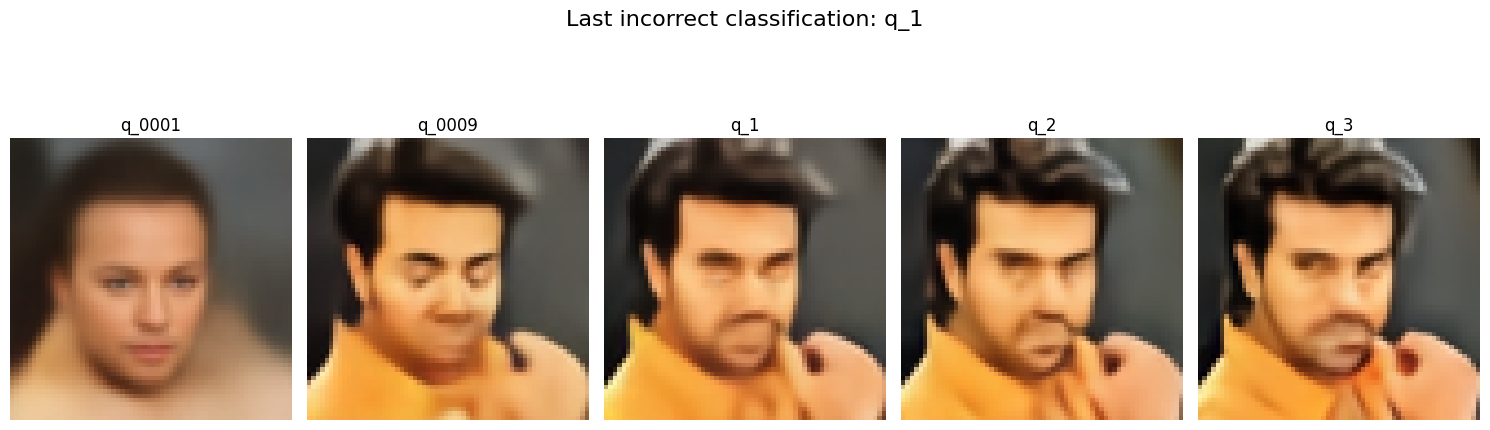

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.0j45w06/m.0j45w06_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.0j45w06/m.0j45w06_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.0j45w06/m.0j45w06_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.0j45w06/m.0j45w06_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.0j45w06/m.0j45w06_0002.png


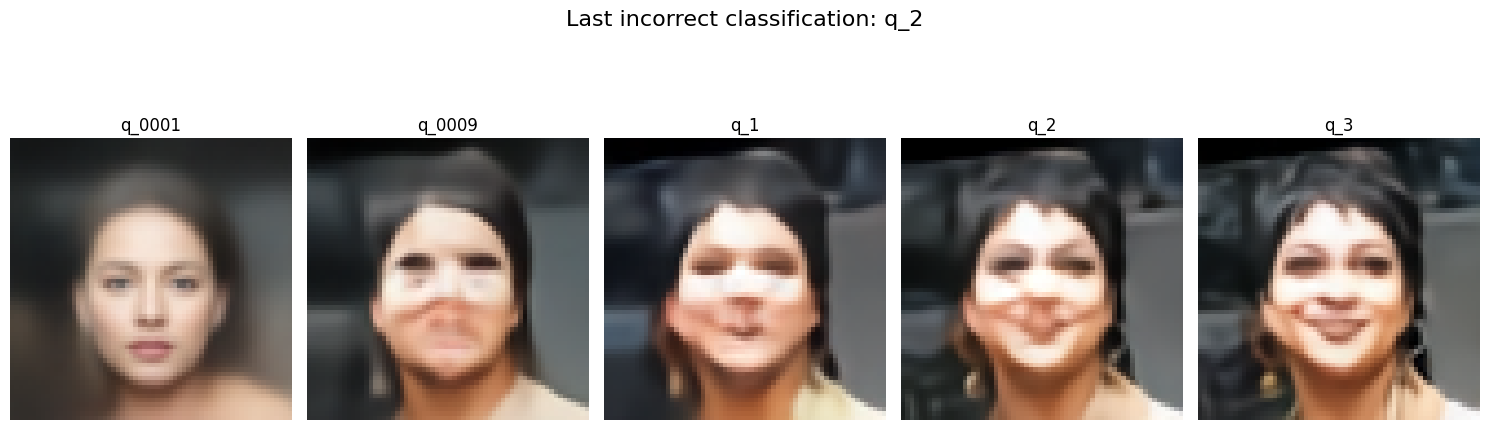

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.04cv0ph/m.04cv0ph_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.04cv0ph/m.04cv0ph_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.04cv0ph/m.04cv0ph_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.04cv0ph/m.04cv0ph_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.04cv0ph/m.04cv0ph_0002.png


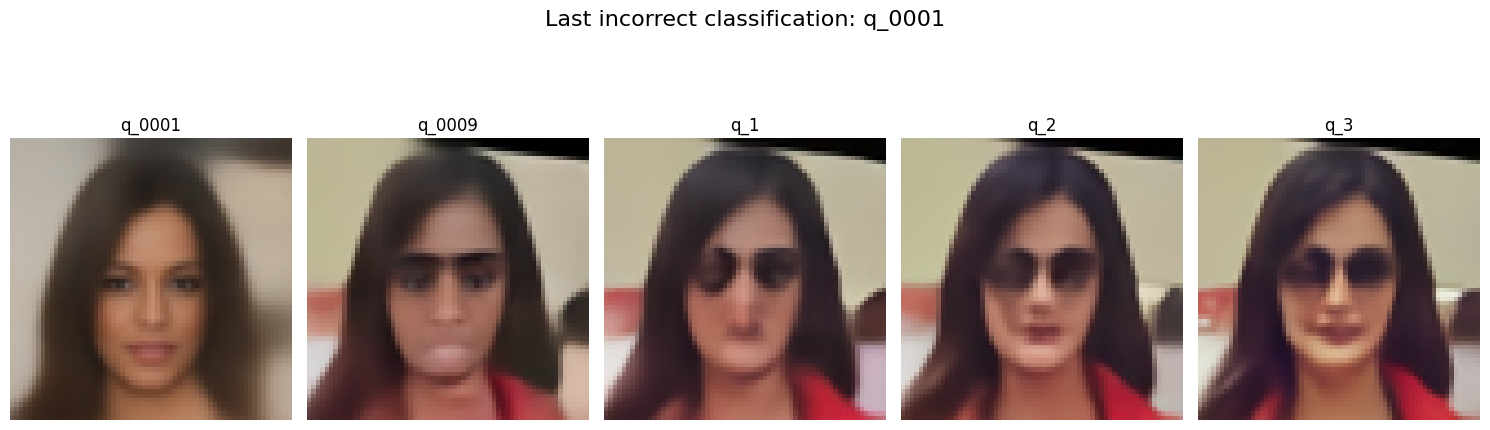

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.0283148/m.0283148_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.0283148/m.0283148_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.0283148/m.0283148_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.0283148/m.0283148_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.0283148/m.0283148_0002.png


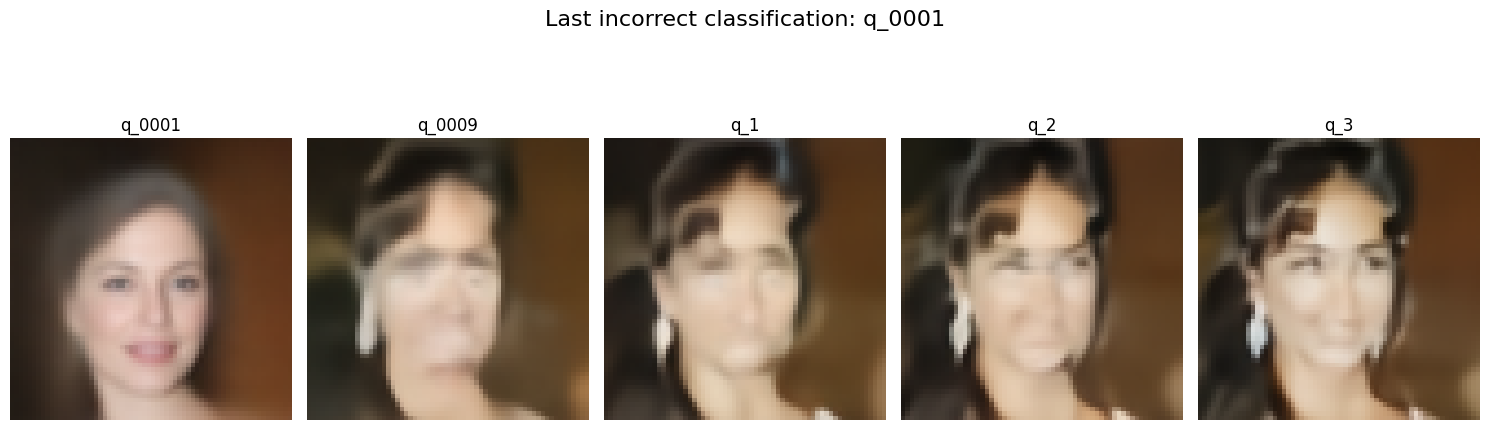

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.0k28ny5/m.0k28ny5_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.0k28ny5/m.0k28ny5_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.0k28ny5/m.0k28ny5_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.0k28ny5/m.0k28ny5_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.0k28ny5/m.0k28ny5_0002.png


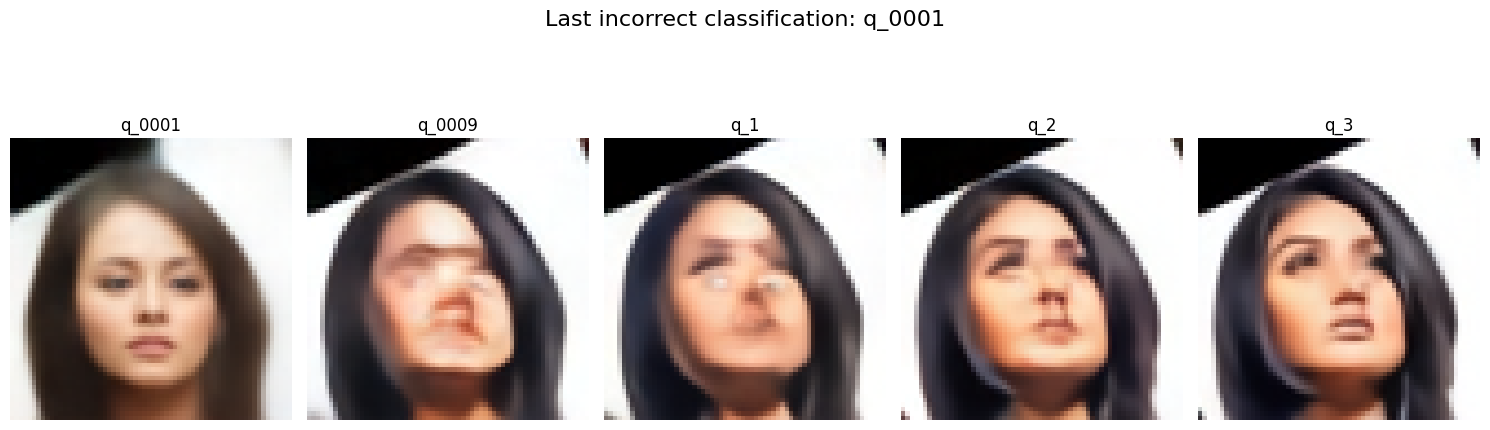

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.02799kb/m.02799kb_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.02799kb/m.02799kb_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.02799kb/m.02799kb_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.02799kb/m.02799kb_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.02799kb/m.02799kb_0003.png


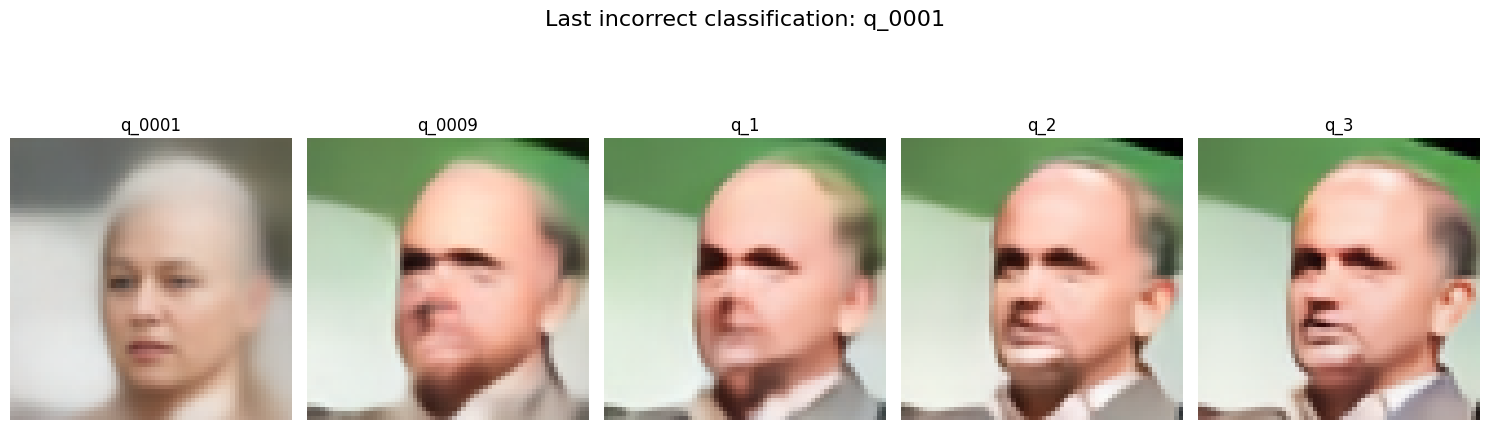

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.043s1q/m.043s1q_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.043s1q/m.043s1q_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.043s1q/m.043s1q_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.043s1q/m.043s1q_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.043s1q/m.043s1q_0002.png


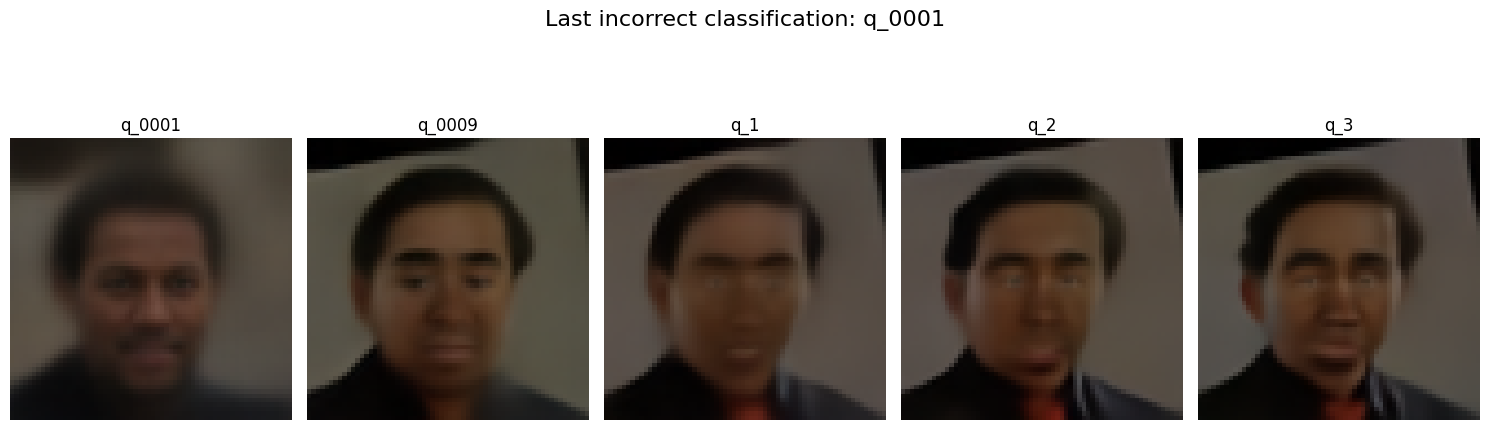

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.03ykjl1/m.03ykjl1_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.03ykjl1/m.03ykjl1_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.03ykjl1/m.03ykjl1_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.03ykjl1/m.03ykjl1_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.03ykjl1/m.03ykjl1_0001.png


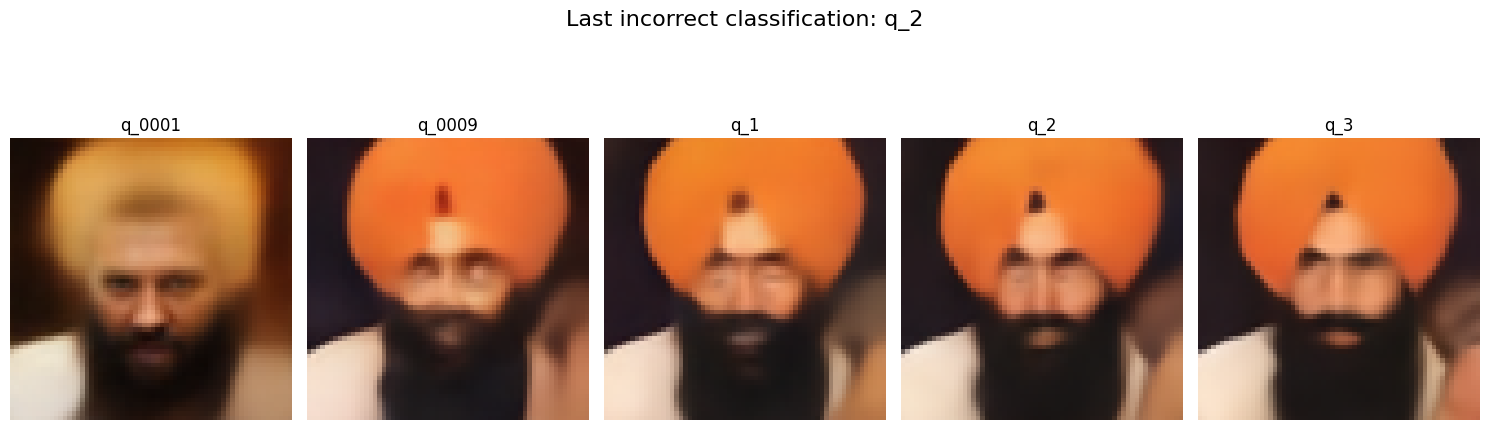

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.02qtcq/m.02qtcq_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.02qtcq/m.02qtcq_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.02qtcq/m.02qtcq_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.02qtcq/m.02qtcq_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.02qtcq/m.02qtcq_0004.png


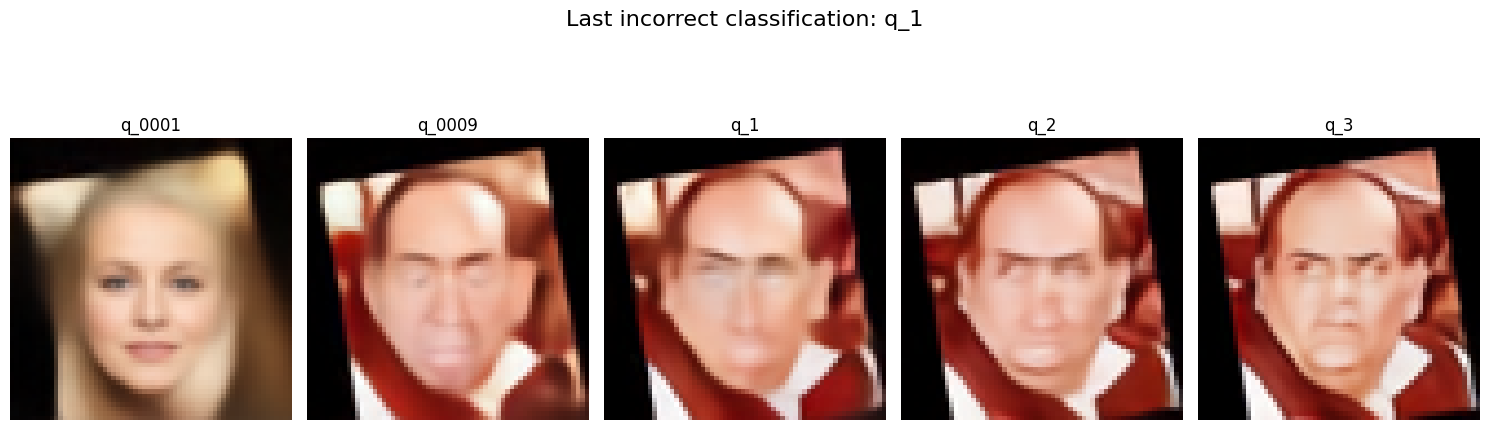

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.09v1dsk/m.09v1dsk_0005.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.09v1dsk/m.09v1dsk_0005.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.09v1dsk/m.09v1dsk_0005.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.09v1dsk/m.09v1dsk_0005.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.09v1dsk/m.09v1dsk_0005.png


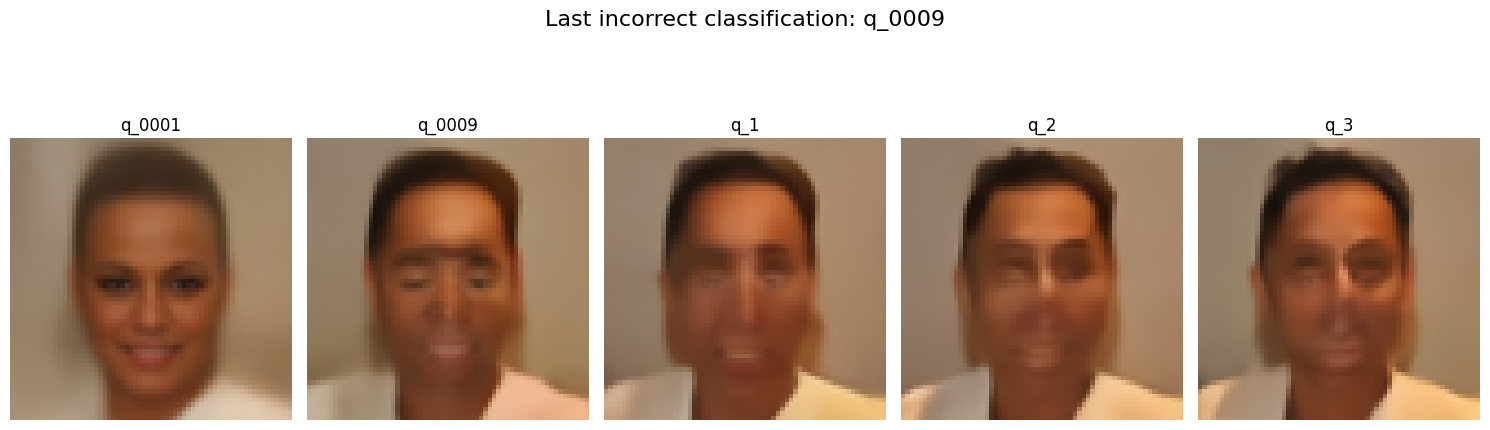

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.0gvvv6p/m.0gvvv6p_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.0gvvv6p/m.0gvvv6p_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.0gvvv6p/m.0gvvv6p_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.0gvvv6p/m.0gvvv6p_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.0gvvv6p/m.0gvvv6p_0002.png


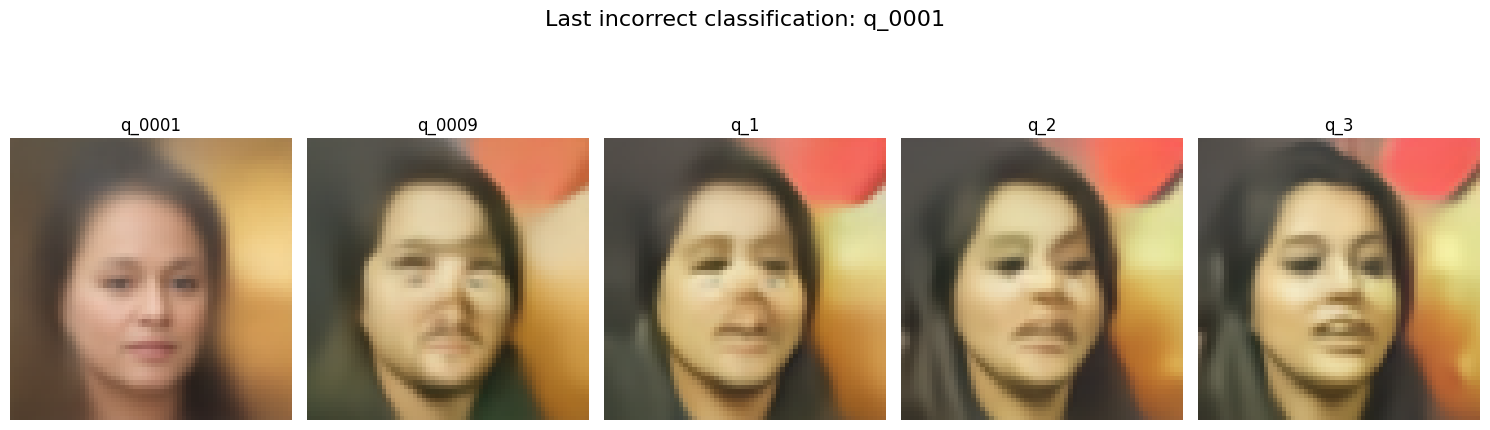

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.02plz65/m.02plz65_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.02plz65/m.02plz65_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.02plz65/m.02plz65_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.02plz65/m.02plz65_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.02plz65/m.02plz65_0004.png


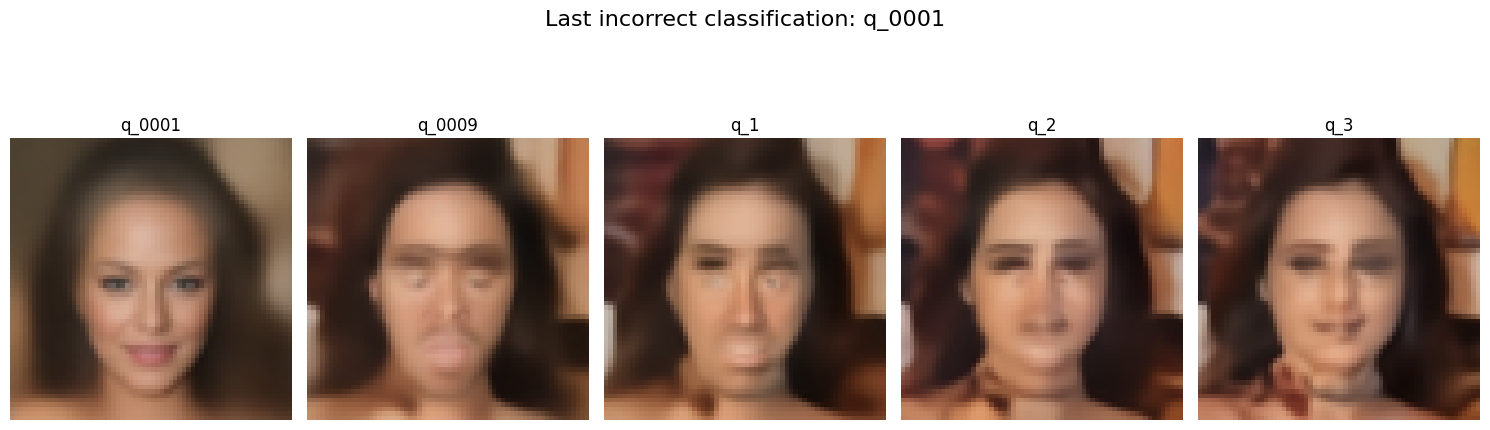

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.01sxrt3/m.01sxrt3_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.01sxrt3/m.01sxrt3_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.01sxrt3/m.01sxrt3_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.01sxrt3/m.01sxrt3_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.01sxrt3/m.01sxrt3_0002.png


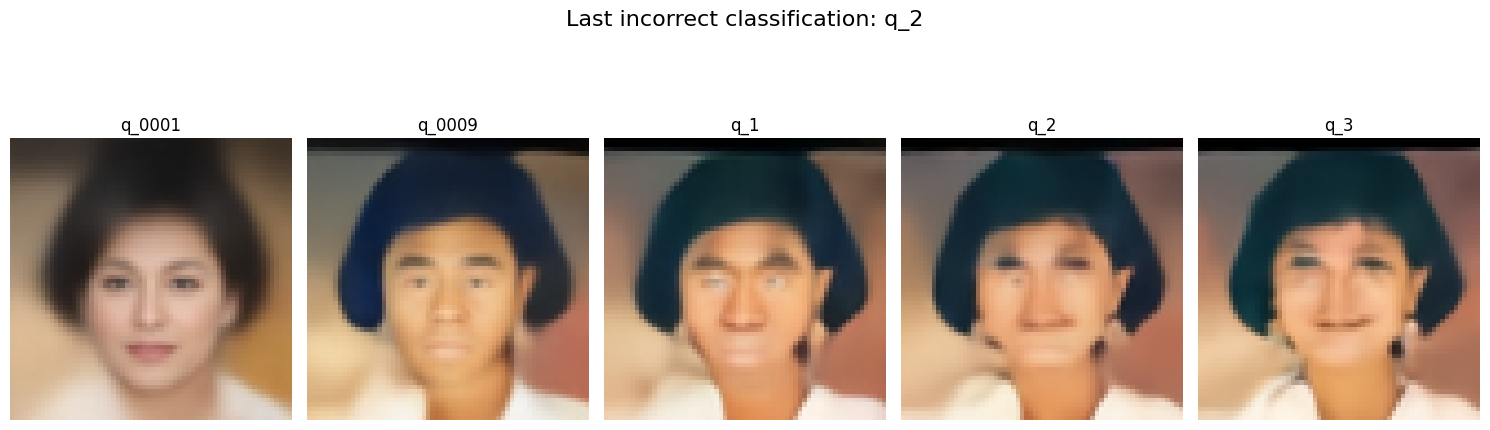

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.0j9ncvv/m.0j9ncvv_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.0j9ncvv/m.0j9ncvv_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.0j9ncvv/m.0j9ncvv_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.0j9ncvv/m.0j9ncvv_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.0j9ncvv/m.0j9ncvv_0001.png


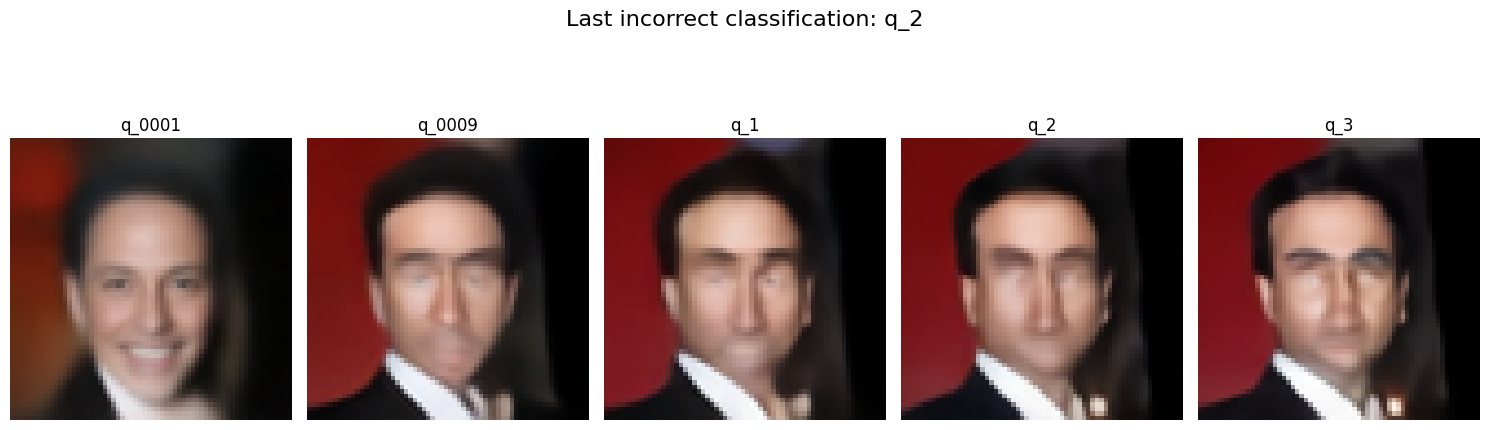

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.0j9p5_f/m.0j9p5_f_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.0j9p5_f/m.0j9p5_f_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.0j9p5_f/m.0j9p5_f_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.0j9p5_f/m.0j9p5_f_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.0j9p5_f/m.0j9p5_f_0003.png


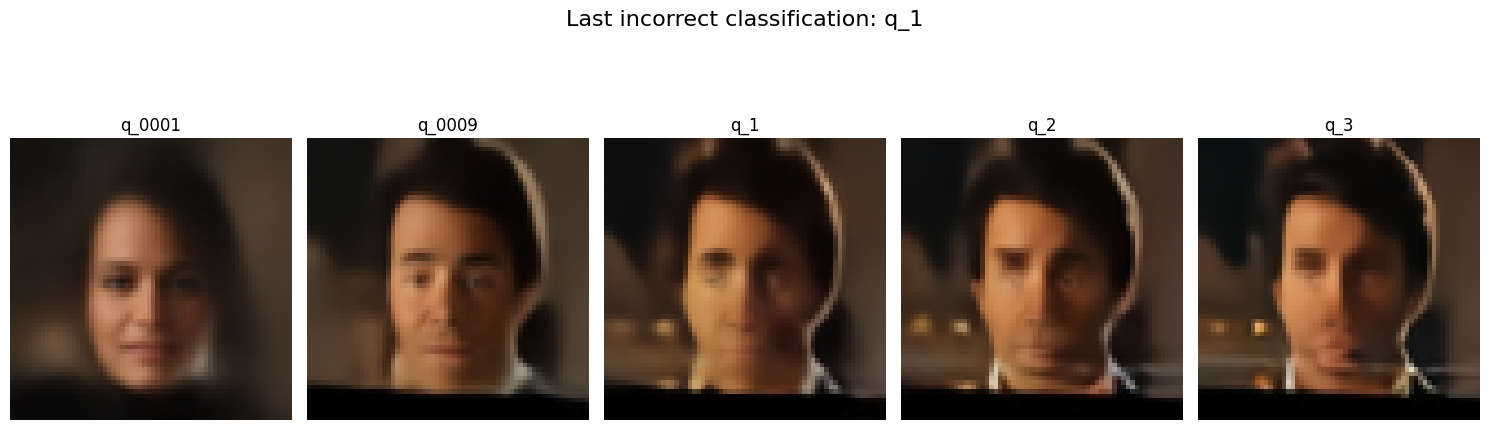

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.03y8_35/m.03y8_35_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.03y8_35/m.03y8_35_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.03y8_35/m.03y8_35_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.03y8_35/m.03y8_35_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.03y8_35/m.03y8_35_0003.png


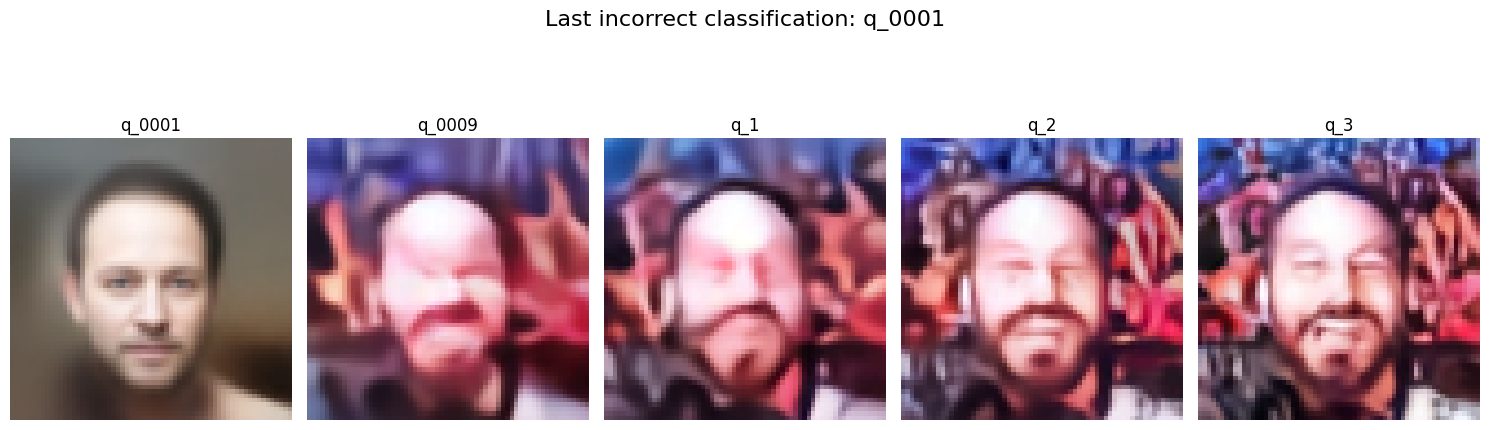

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.05zz4b7/m.05zz4b7_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.05zz4b7/m.05zz4b7_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.05zz4b7/m.05zz4b7_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.05zz4b7/m.05zz4b7_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.05zz4b7/m.05zz4b7_0003.png


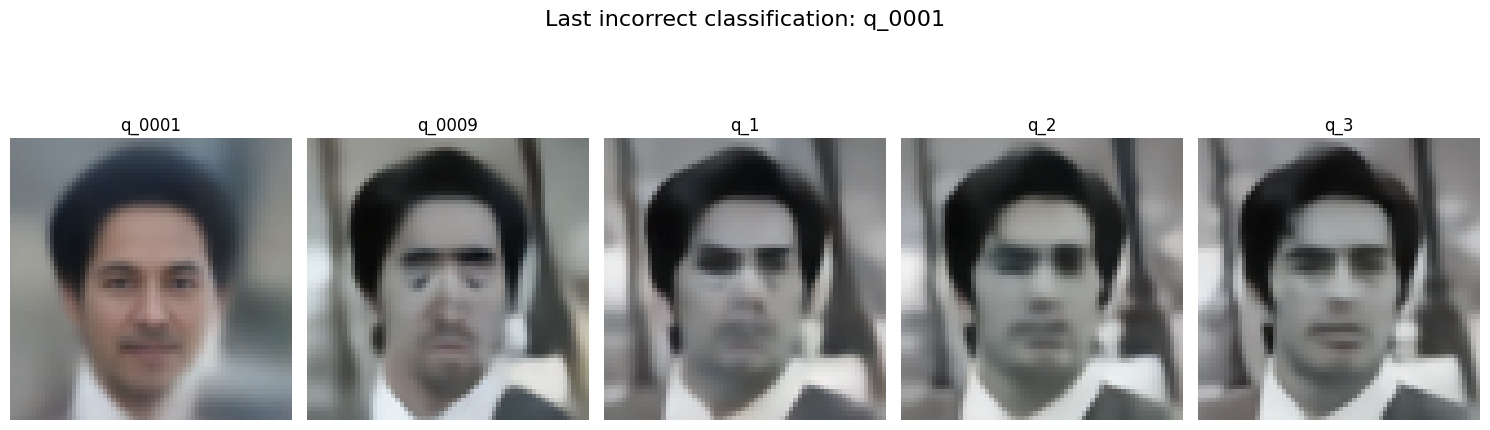

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.0n49g1g/m.0n49g1g_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.0n49g1g/m.0n49g1g_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.0n49g1g/m.0n49g1g_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.0n49g1g/m.0n49g1g_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.0n49g1g/m.0n49g1g_0001.png


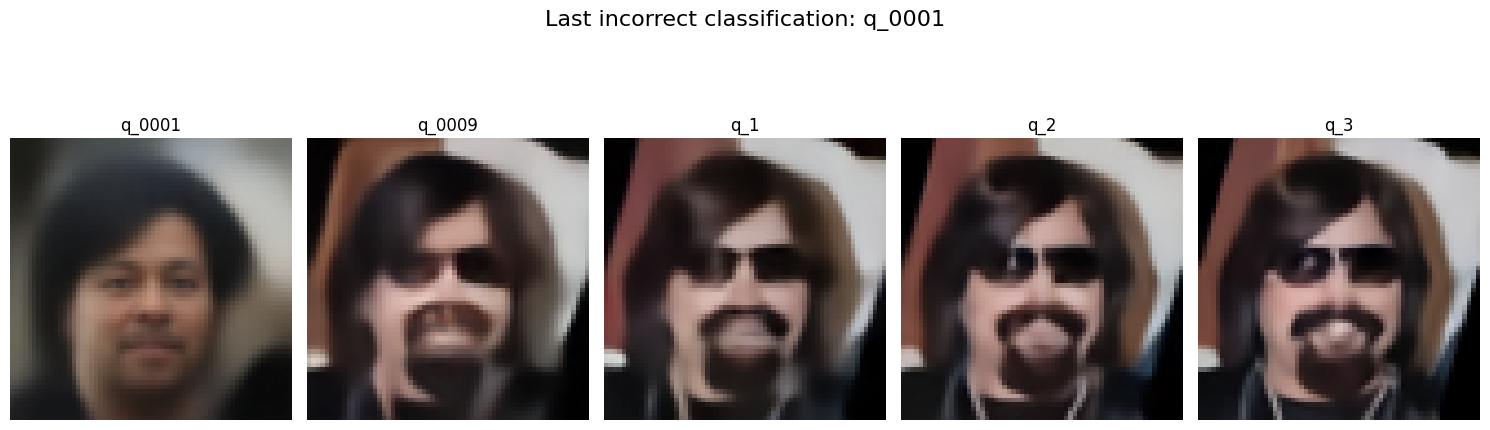

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.03hnrn3/m.03hnrn3_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.03hnrn3/m.03hnrn3_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.03hnrn3/m.03hnrn3_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.03hnrn3/m.03hnrn3_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.03hnrn3/m.03hnrn3_0002.png


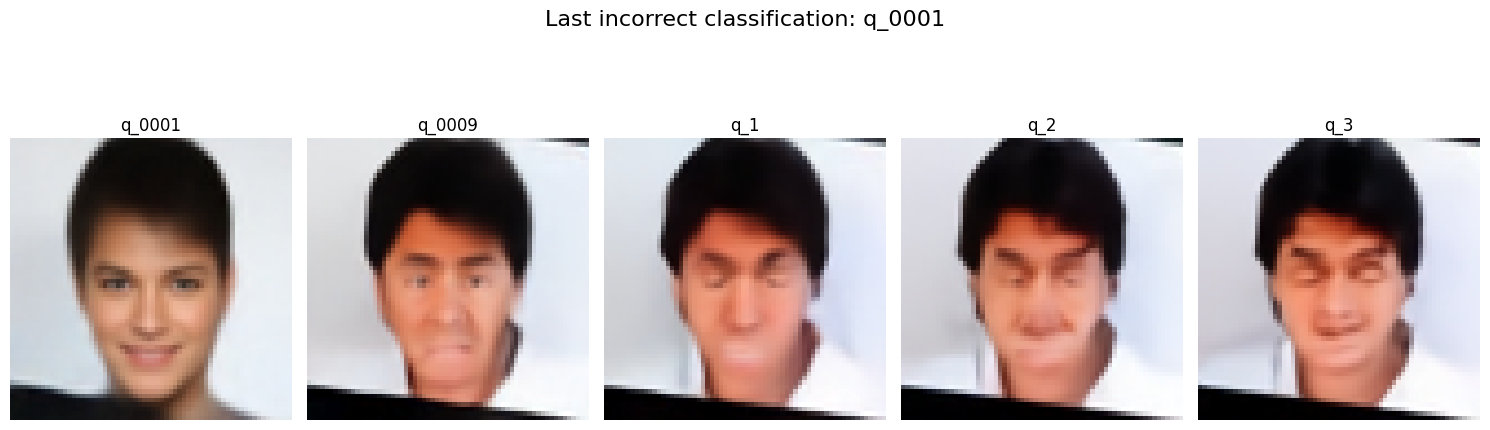

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Indian/m.02qytnc/m.02qytnc_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Indian/m.02qytnc/m.02qytnc_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Indian/m.02qytnc/m.02qytnc_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Indian/m.02qytnc/m.02qytnc_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Indian/m.02qytnc/m.02qytnc_0001.png


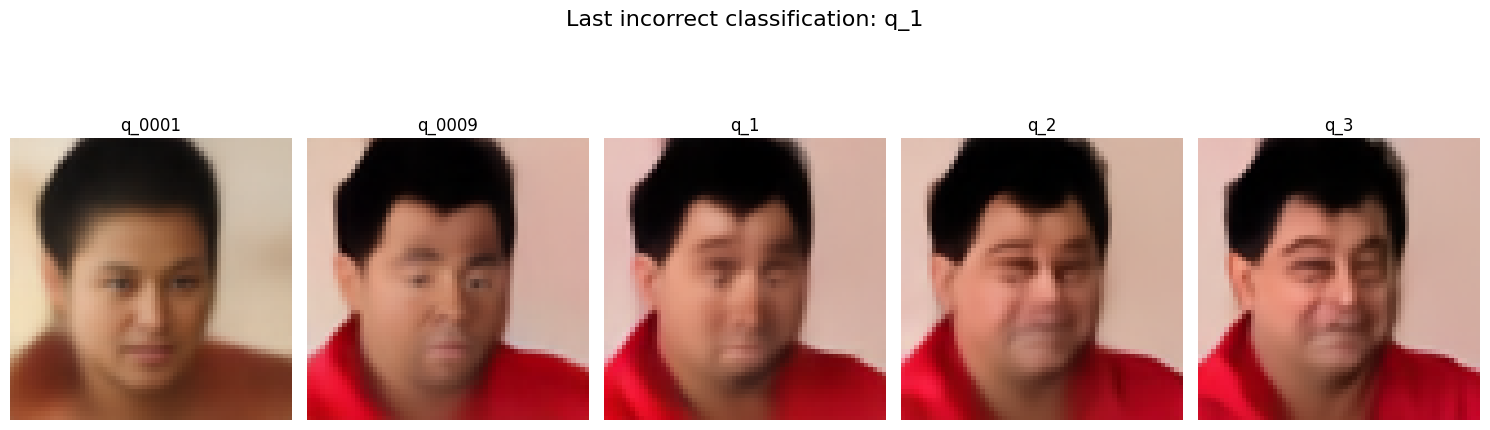

In [190]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

filtered_keys = [key for key, value in wrong_preds_of_interest.items() if value != 'q_3']
sampled_keys = random.sample(filtered_keys, k=20)
# print(selected_keys)

for file_name in sampled_keys:
    wrong_pred_quality = wrong_preds_of_interest[file_name]
    image_files = []
    for quality in qualities:
        image_files.append(f'{ROOT}/{"cheng2020-attn"}/{dataset_name}/{quality}/{file_name}')
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        print(f'{image_files[i]}')
        img = mpimg.imread(image_files[i])
        ax.imshow(img)
        ax.set_title(qualities[i])
        ax.axis('off')
    fig.suptitle(f'Last incorrect classification: {wrong_pred_quality}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the top to fit the suptitle

    # Show the plot
    plt.show()


In [156]:
RFW_ROOT = '/media/global_data/fair_neural_compression_data/datasets/RFW/data_64'

hair_type


KeyError: 'African/m.076yq88/m.076yq88_0001.png'

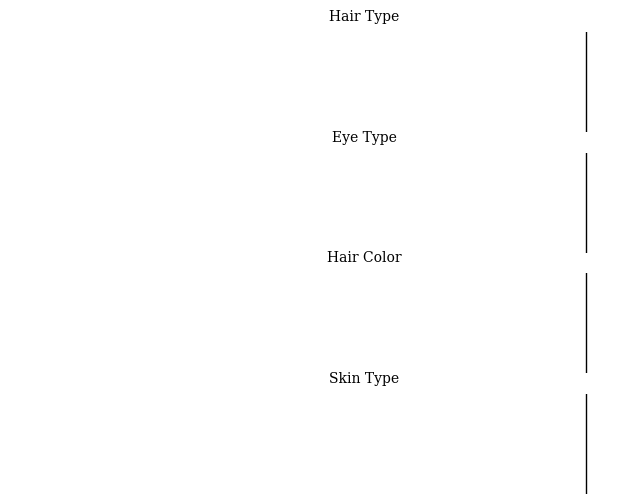

In [40]:
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.pyplot as plt

bpps = bpp_data['cheng2020-attn']['celebA']

selected_images = [
    'African/m.076yq88/m.076yq88_0001.png',
    'Asian/m.01wh03h/m.01wh03h_0003.png',
    'Caucasian/m.03plx_/m.03plx__0001.png',
    'Indian/m.04y6dj9/m.04y6dj9_0001.png',
]
races = ['African', 'Asian', 'Caucasian', 'Indian']
race_attributes = ['hair_type', 'eye_type', 'hair_color', 'skin_type']

mpl.style.use('seaborn-v0_8-colorblind')
plt.rcParams["font.family"] = "serif"
fig, axes = plt.subplots(4, 6, figsize=(8, 6))
plt.setp(axes, xticks=[], yticks=[], frame_on=False) # remove black borders, no xy axis
for ax in axes:
    ax[-1].axvline(x=0.5, color='black', linestyle='-', linewidth=1)

for i, race_attribute in enumerate(race_attributes):
    text_x = (len(qualities) + 4) / 2 - 0.5  # Centered text position
    axes[i, 0].text(text_x, 1.15, ' '.join(race_attribute.split('_')).title(), ha='center', va='center', transform=axes[i, 0].transAxes)
    
for i, (file_name, race) in enumerate(zip(selected_images, races)):
    wrong_preds_of_interest = get_wrong_preds(race, race_attributes[i])
    print(race_attributes[i])
    last_incorrect_quality = wrong_preds_of_interest[file_name]
    last_incorrect_index = qualities.index(last_incorrect_quality)
    for j in range(len(qualities) + 1):
        if j == 0:
            axes[i][j].set_ylabel(f'{race}')
        if j == len(qualities):
            image_path = f'{RFW_ROOT}/{file_name}'
            if i == len(selected_images) - 1:
                axes[i][j].set_xlabel(f'Original')
        else:
            color = 'r' if j <= last_incorrect_index else 'g'
            rect = patches.Rectangle((0, 0), 63, 63, linewidth=7, edgecolor=color, facecolor='none')
            axes[i][j].add_patch(rect)
            image_path = f'{ROOT}/{"cheng2020-attn"}/{dataset_name}/{qualities[j]}/{file_name}'
            if i == len(selected_images) - 1:
                axes[i][j].set_xlabel(f'{"{:.3f}".format(bpps[qualities[j]])} bpp')
        img = mpimg.imread(image_path)
        axes[i][j].imshow(img)

plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.3)  # Adjust bottom and top margins as needed
plt.tight_layout(rect=[0, 0, 1, 0.1])
plt.savefig('/home/rasta/fair compression/fair-neural-compression-eval/plots/first_page_fig.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [212]:
bpps

{'q_0001': 0.027202235793998834,
 'q_0009': 0.1385776092247803,
 'q_1': 0.20972122410817096,
 'q_2': 0.31385972614460156,
 'q_3': 0.4503114667617908}